# Extracting explanations from a sparse audio classifier

In [1]:
from audIBle.nn.autoencoders import SpecAE
from audIBle.nn.sparse_classif import SparseClassifier
from audIBle.data.datasets import UrbanSound8k

import torch
import numpy as np
import json
import os

In [2]:
config_ids = [f"00{i}" for i in range(1,7)]
seed=42

conf_id = "005"
exp_name = f"{conf_id}_sparse_classif_urbasound8k_{seed}"
exp_root = os.path.join(os.environ["EXP_ROOT"], "train/SAE/ae_debug/",exp_name)

with open(os.path.join(exp_root, "config.json"), 'r') as fh:
    cfg = json.load(fh)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

autoencoder = SpecAE(**cfg["model"]["autoencoder"])
ae_ckpt_path = cfg["model"]["ae_ckpt_path"]
if ae_ckpt_path is not None:
    ae_ckpt = torch.load(ae_ckpt_path, map_location=device, weights_only=True)
    autoencoder.load_state_dict(ae_ckpt)

# prepare the sparse classifier
classif_params = cfg["model"]["classifier"]
classif_params["autoencoder"] = autoencoder
model = SparseClassifier(**classif_params)

In [4]:
# classifier checkpoint
classif_ckpt_path = os.path.join(exp_root,"best_model.pth")
ckpt = torch.load(classif_ckpt_path, map_location=device, weights_only=True)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [5]:
data_root = "/lium/corpus/vrac/tmario/sed/urbansound8k/urbansound8k"
fold_test = 10
dataset = UrbanSound8k(csv_path=os.path.join(data_root, "metadata/UrbanSound8K.csv"),
                           audio_dir=os.path.join(data_root, "audio"),
                           sample_rate=cfg["sample_rate"],
                           folds_to_use=[10],)

In [6]:
def extract_explanation(model, tau, input_data, label, device, spec_scale="log"):
    model.to(device)

    # retrieve the phase of the audio to reconstruct the explanation in the audio domain
    _, phase = model.get_stft(input_data)

    # extract all of the representations
    all_rep = model.forward_return_all(input_data.to(device))
    # pooled sparse representation (used to make the decision)
    Z = all_rep["sparse_latent_pooled"]
    latent = all_rep["ae_hidden"]
    attention_weights = all_rep["attention_weights"]
    # weights of the linear classification head
    W_c = model.classif_head.weight
    # weights of the SAE decoder
    W_d_sae =  model.sae.decoder.weight

    # predicted class 
    pred = torch.argmax(torch.nn.functional.softmax(all_rep["logits"], dim=-1),dim=-1)
    n_classes = W_c.shape[0]
    
    explain = {"model_outputs": all_rep, "explain": {}}

    for c in range(n_classes):
        # select the weights of the classification layer according to class c
        w_class = W_c[c,:]
        # compute class relevance based on classification head weights
        #TODO check the formula w.r.t. the JSALT code
        r_c = w_class * Z 
        r_c = r_c / r_c.max() 
        # binarize based on a threshold
        mask = r_c > tau

        Z_seq = all_rep["sparse_latent"]
        # mask the latent representation according to the relevant dimensions
        Z_seq_mask = Z_seq * mask.unsqueeze(1)

        # decode the latent space of the SAE after selecting the relevant dimensions 
        sae_dec_mask = model.sae.decoder(Z_seq_mask)

        ### --- First way of extracting explanation ---
        ### The output of the SAE is used to create a soft mask over its input. The soft-masked version of the SAE input is then decoded using the decoder of the audio AE. 
        # soft mask for explanation extraction
        # print(f"{sae_dec_mask.shape=}")
        # print(f"{sae_dec_mask.sum(dim=-1, keepdim=True).shape=}")
        soft_mask = sae_dec_mask / sae_dec_mask.sum(dim=-1, keepdim=True)

        # masked latent representation for explanation extraction
        latent_mask = soft_mask * latent

        # decode the masked latent representation
        spec_soft_mask = model.audio_ae.decode(latent_mask.permute(0,2,1))
        # print(f"{attention_weights.shape=}")
        spec_soft_mask_att = spec_soft_mask * attention_weights.permute(0,2,1)

        ### --- Second way of extracting explanations ---
        ### The latent space of the SAE is masked according to the relevant components. This masked latent is decoded using SAE decoder, and then the audio AE decoder.
        spec_dec_mask = model.audio_ae.decode(sae_dec_mask.permute(0,2,1))
        spec_dec_mask_att = spec_dec_mask * attention_weights.permute(0,2,1)

        explain["explain"][f"class_{c}"] = {"relevance": r_c, 
                                 "bin_relevance": mask, 
                                 "explanation_V1": spec_soft_mask,
                                 "explanation_V2": spec_dec_mask,
                                 "explanation_att_V1": spec_soft_mask_att,
                                 "explanation_att_V2": spec_dec_mask_att,
                                 "label": label, 
                                 "pred": pred,
                                 "spec_phase": phase}
    return explain

In [7]:
import matplotlib.pyplot as plt

def plot_explain_spec(x_orig, x_explain1, code_seq, attention_weights=None, **plt_kw):
    sr = plt_kw.get("samplerate", 22050)
    class_id = plt_kw.get("class_id", "")
    fig, axs = plt.subplots(4, 1, figsize=(7, 10), sharex=True, layout="tight")
    title_info = plt_kw.get("title", "")
    # Plot original and explanation spectrograms
    for ax, spec, title in zip(
        axs[:3], [x_orig, x_explain1, code_seq], [f"Original", f"Explanation", f"Sparse codes"]
    ):
        # assume input is torch.Tensor or np.ndarray, shape (1, freq, time) or (freq, time)
        if hasattr(spec, "detach"):
            spec = spec.detach().cpu().squeeze().numpy()
        else:
            spec = np.squeeze(spec)
        im = ax.imshow(
            spec,
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        if title == "Sparse codes":
            is_code = True
        else:
            is_code=False
        title  = title + title_info
        ax.set_title(title)
        # Set y-axis in Hz
        if is_code:
            n_dim = code_seq.shape[0]
            y_ticks = np.linspace(0, n_dim - 1, 4)
            y_labels = np.linspace(0, n_dim, 4, dtype=int)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)
            ax.set_ylabel("Dimension index")
            # Set x-axis in seconds
            n_time = code_seq.shape[-1]
            x_ticks = np.linspace(0, n_time - 1, 6)
            x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels)
            # Place colorbar on top
            cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)
            cbar.ax.xaxis.set_ticks_position('top')
            cbar.ax.xaxis.set_label_position('top')
        else:
            n_freq = spec.shape[0]
            y_ticks = np.linspace(0, n_freq - 1, 6)
            y_labels = np.linspace(0, sr // 2, 6, dtype=int)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_labels)
            ax.set_ylabel("Frequency (Hz)")
            # Set x-axis in seconds
            n_time = spec.shape[1]
            x_ticks = np.linspace(0, n_time - 1, 6)
            x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels)
            # Place colorbar on top
            cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)
            cbar.ax.xaxis.set_ticks_position('top')
            cbar.ax.xaxis.set_label_position('top')

    # Plot attention weights
    if attention_weights is not None:
        idx_ = 3
        if hasattr(attention_weights, "detach"):
            attn = attention_weights.detach().cpu().squeeze().numpy()
        else:
            attn = np.squeeze(attention_weights)
        # attn shape: (time,) or (1, time)
        axs[3].plot(attn, color="tab:blue")
        axs[3].set_ylabel("Attention weight")
        axs[3].set_title("Attention weights over time")
        axs[3].set_ylim(0, np.max(attn) * 1.1)
        n_time = attn.shape[-1]
        x_ticks = np.linspace(0, n_time - 1, 6)
        x_labels = np.round(np.linspace(0, n_time / sr, 6), 2)
        axs[3].set_xticks(x_ticks)
        axs[3].set_xticklabels(x_labels)
        # Align attention x-axis with spectrograms
        axs[3].set_xlim(axs[0].get_xlim())
        axs[idx_].grid()
    axs[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

def get_stft_param(cfg, add_pad=False):
    n_fft = cfg["model"]["autoencoder"]["n_fft"]
    hop_length = cfg["model"]["autoencoder"]["hop_length"]
    win_length = cfg["model"]["autoencoder"]["win_length"]
    if add_pad:
        pad = cfg["model"]["autoencoder"]["pad"]
        center = cfg["model"]["autoencoder"]["center"]
    if add_pad:
        return {"n_fft": n_fft, "hop_length": hop_length, "win_length": win_length, "pad": pad, "center": center}
    
    return {"n_fft": n_fft, "hop_length": hop_length, "win_length": win_length}


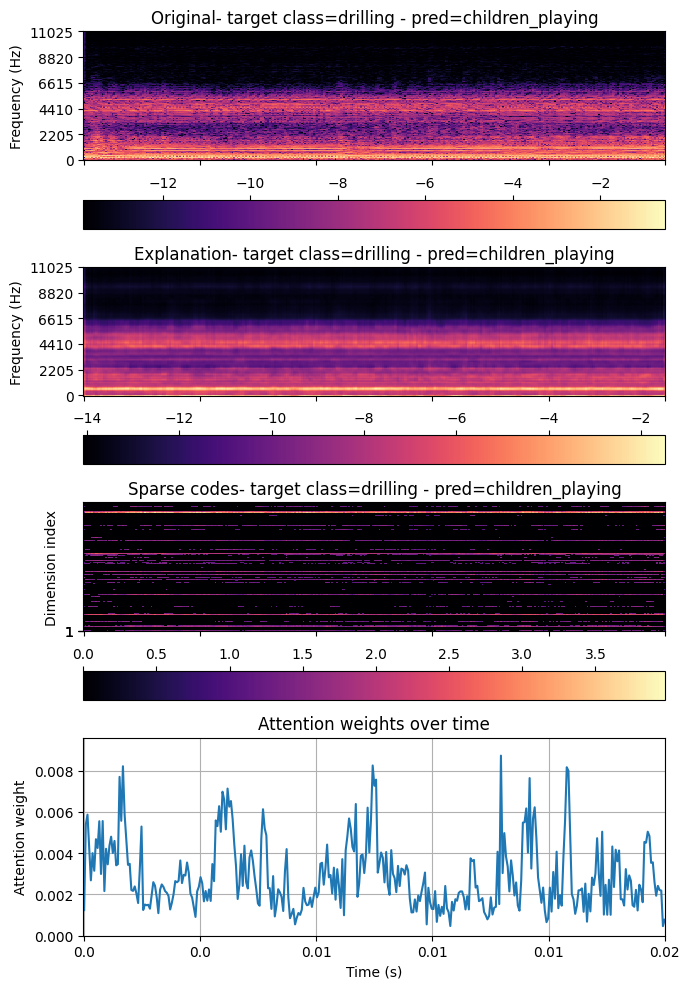

Original


/tmp/ipykernel_3107624/519492581.py:54: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:1023.)
  x1 = torch.istft(stft1.squeeze(), n_fft=stft_param["n_fft"], win_length=stft_param["win_length"], hop_length=stft_param["hop_length"])


Explanation


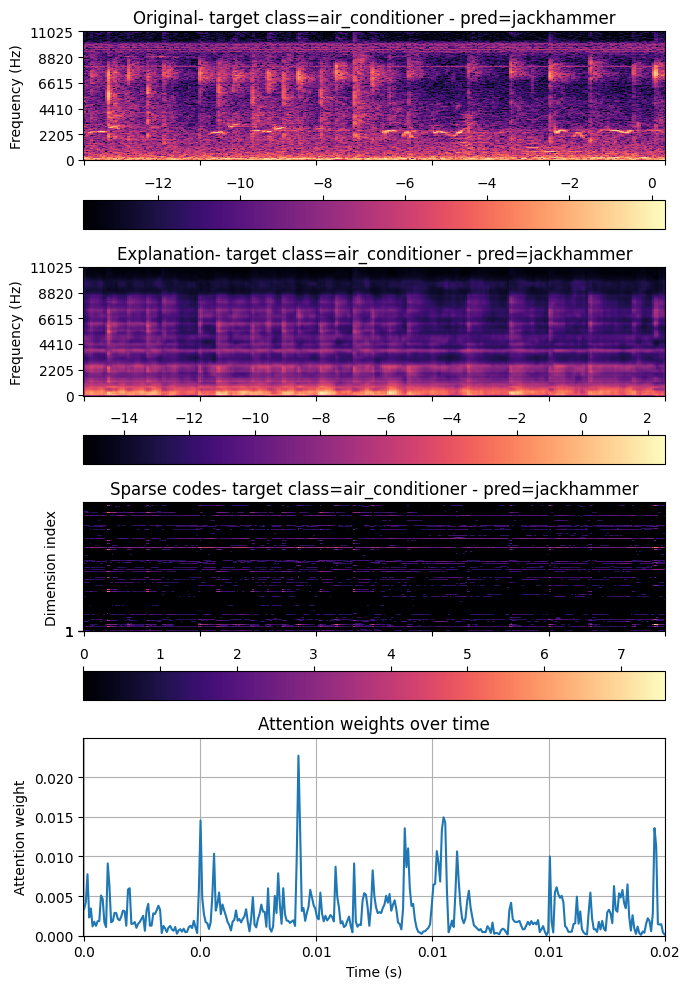

Original


Explanation


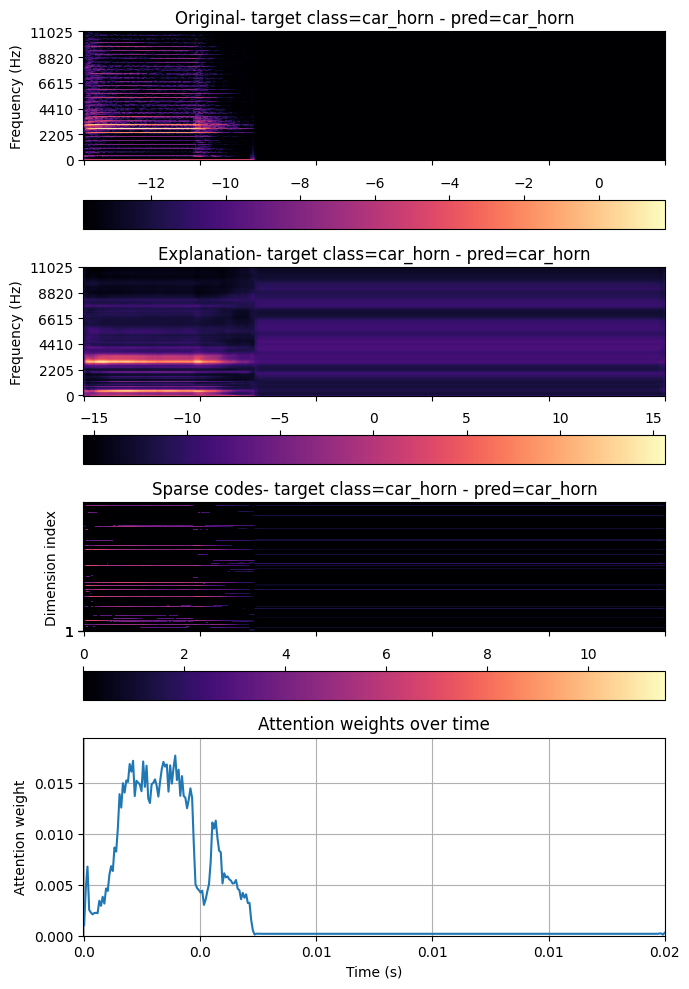

Original


Explanation


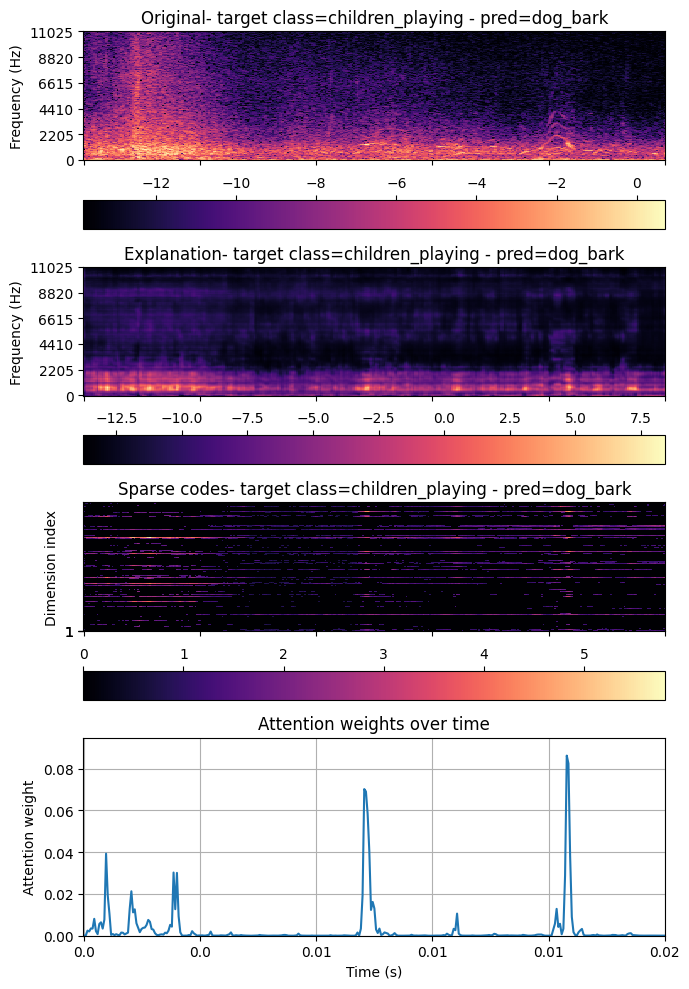

Original


Explanation


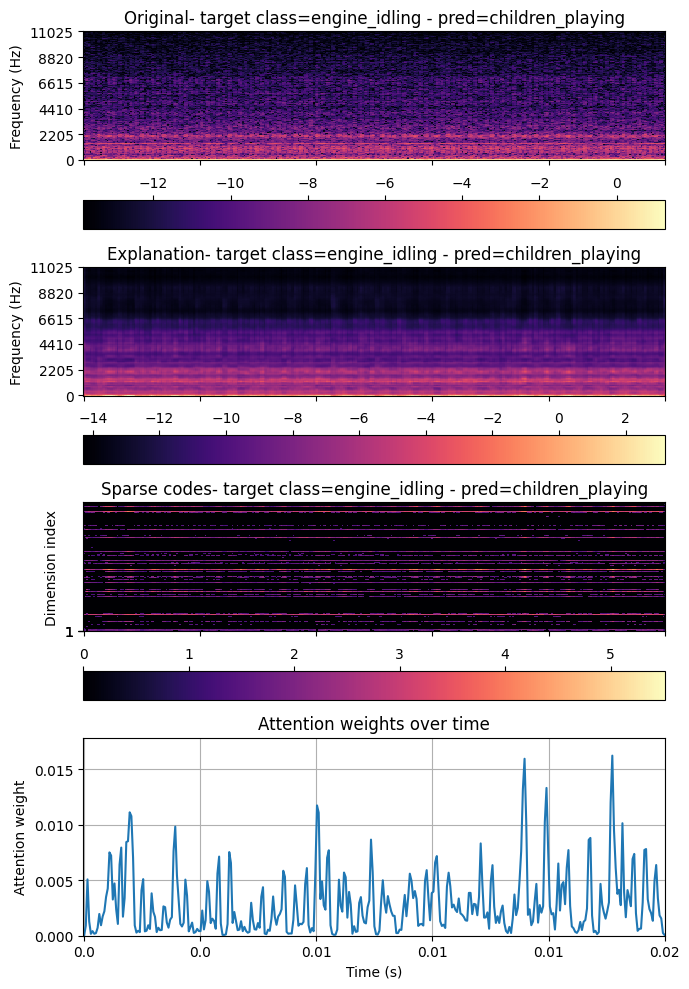

Original


Explanation


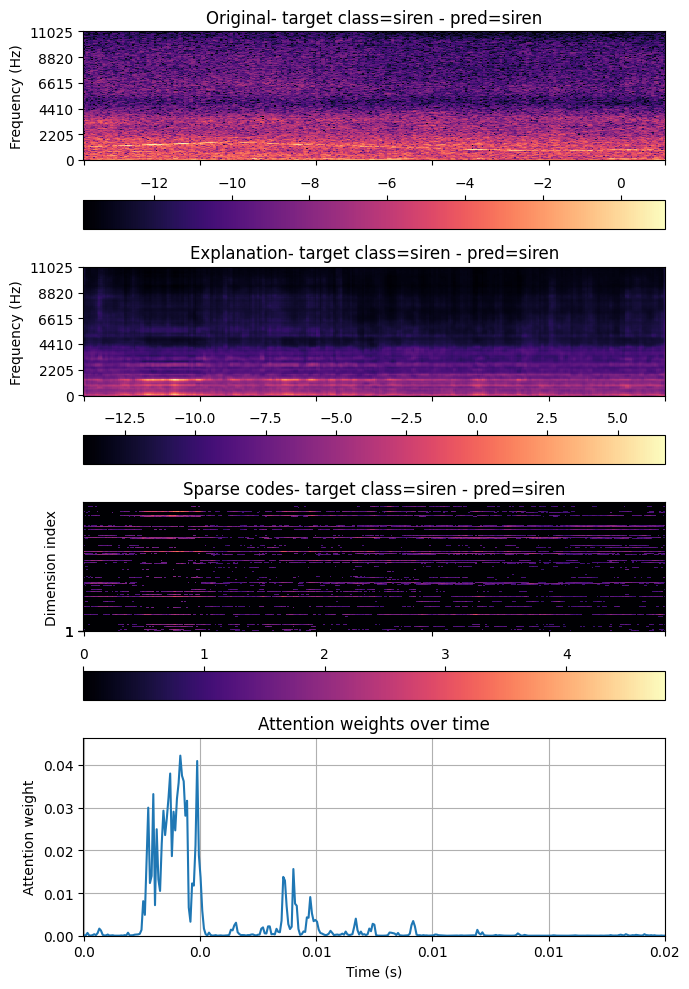

Original


Explanation


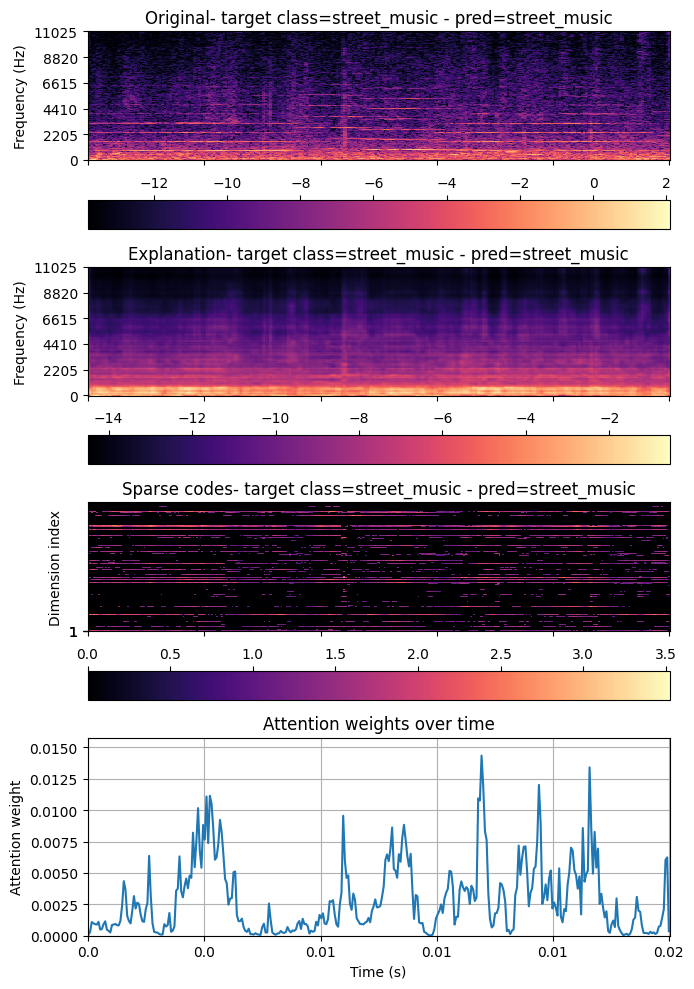

Original


Explanation


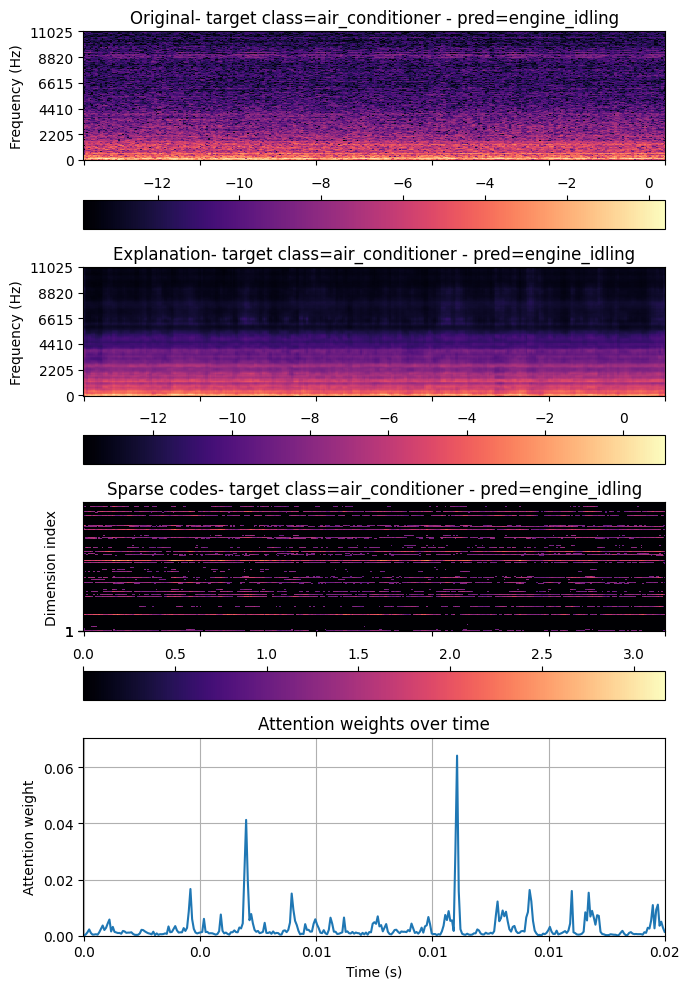

Original


Explanation


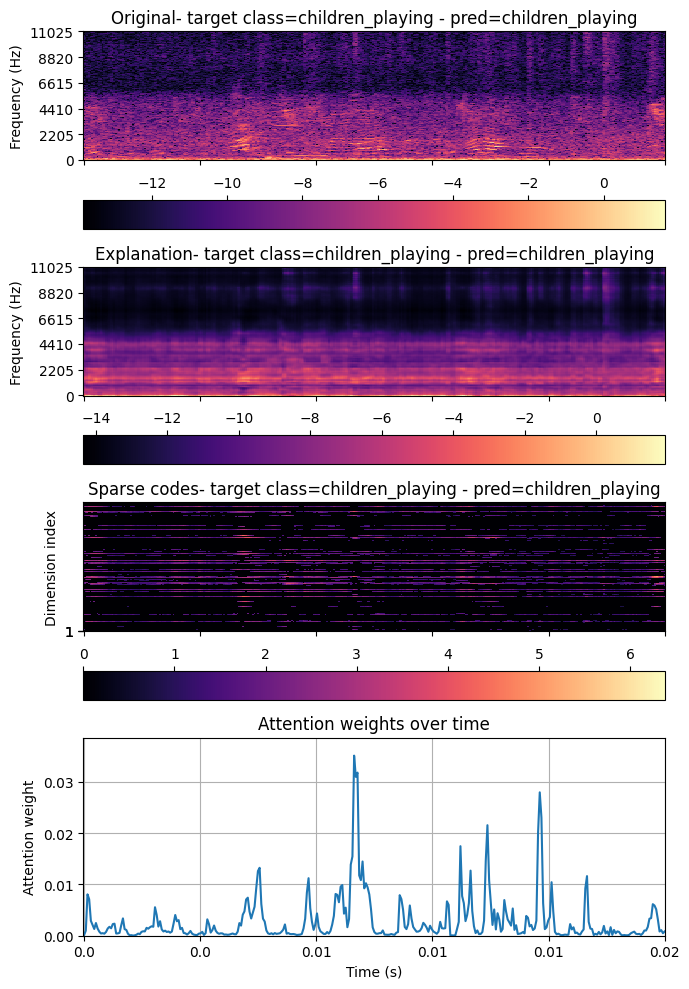

Original


Explanation


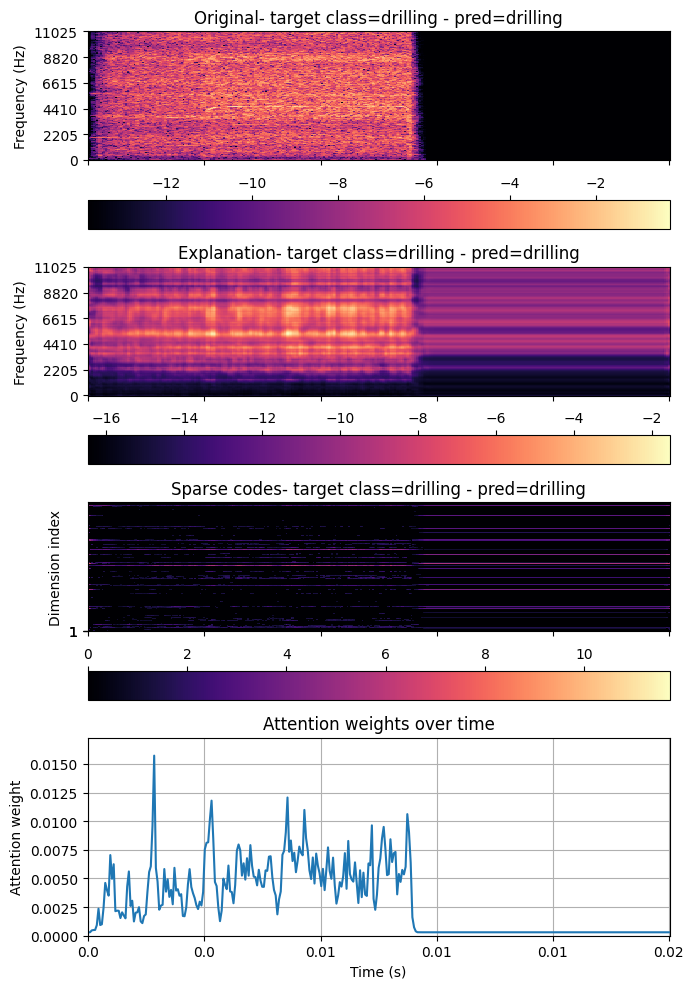

Original


Explanation


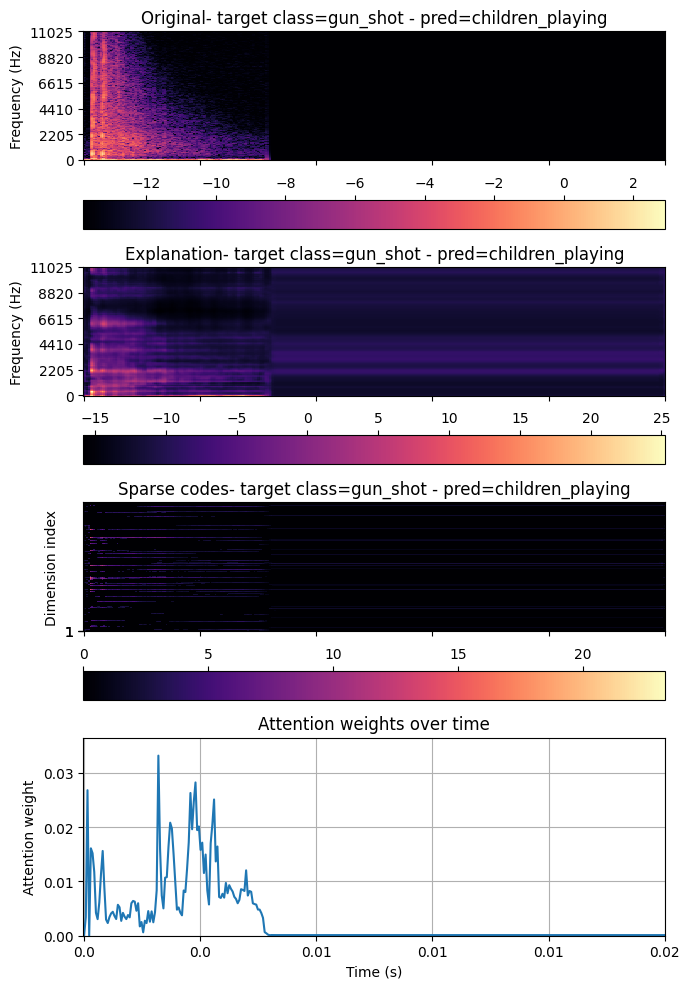

Original


Explanation


In [9]:
model.to(device)
W_c = model.classif_head.weight
W_sae_d = model.sae.decoder.weight
tau = 0.2

from torch.utils.data import DataLoader
import IPython.display as ipd

test_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
classes = dataset.classes
for i_data, (wav, label) in enumerate(test_loader):
    #wav, label = dataset[i_data]
    #wav = wav.unsqueeze(0)
    label = label.squeeze()
    # all_rep = model.forward_return_all(wav.to(device))

    # for k,v in all_rep.items():
    #     print(f"{k}: {v.shape}")
    
    
    explain = extract_explanation(model, tau, wav, label, device)
    model_outputs = explain["model_outputs"]   
    # for k in model_outputs.keys():
    #     print(k)

    pred_class = explain["explain"][f"class_{label}"]["pred"]
    pred_class = pred_class.item()
    
    spec_orig = model_outputs["spec"]
    code_seq = model_outputs["sparse_latent"]
    attention_weights = model_outputs["attention_weights"]
    
    X1 = explain["explain"][f"class_{pred_class}"]["explanation_V2"]
    #X1 = model_outputs["spec_hat"]
    # X2 = explain["explain"][f"class_{pred_class}"]["explanation_V2"]

    plot_explain_spec(x_orig=spec_orig, 
                    x_explain1=X1, 
                    code_seq=code_seq.transpose(1,2), 
                    attention_weights=attention_weights, 
                    class_id="pouet", 
                    samplerate = cfg["sample_rate"],
                    title=f"- target class={classes[label.item()]} - pred={classes[pred_class]}")
    
    # generate audio signals from explanations
    stft_param = model.audio_ae.get_stft_params()
    if stft_param["scale"] == "log":
        X1_lin = torch.exp(X1)
        # X2_lin = torch.exp(X2)
    phi = explain["explain"][f"class_{pred_class}"]["spec_phase"]

    stft1 = X1_lin * torch.exp(1j*phi)
    # stft2 = X2_lin * torch.exp(1j*np.pi*phi)
    x1 = torch.istft(stft1.squeeze(), n_fft=stft_param["n_fft"], win_length=stft_param["win_length"], hop_length=stft_param["hop_length"])
    # x2 = torch.istft(stft2.squeeze(), **stft_param)

    print("Original")
    ipd.display(ipd.Audio(wav.detach().cpu().squeeze().numpy(),rate=cfg["sample_rate"]))
    print("Explanation")
    ipd.display(ipd.Audio(x1.detach().cpu().squeeze().numpy(),rate=cfg["sample_rate"]))

    
    # if pred_class.item() != label.item():
    #     print("Wrong classification!")
    #     plot_explain_spec(x_orig=spec_orig, 
    #                 x_explain=explain["explain"][f"class_{pred_class.item()}"]["relevant_spec"], 
    #                 attention_weights=attention_weights, 
    #                 class_id="pouet", 
    #                 samplerate = cfg["sample_rate"],
    #                 title=f"- pred class={classes[pred_class.item()]} - target={classes[label.item()]}")
        

    if i_data >=10:
        break

### Plot the distribution of activated sparse dimensions per class

### Visualize the sparse sequence (before pooling) for a few examples